In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4
%config InlineBackend.figure_format = 'retina'

## 1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

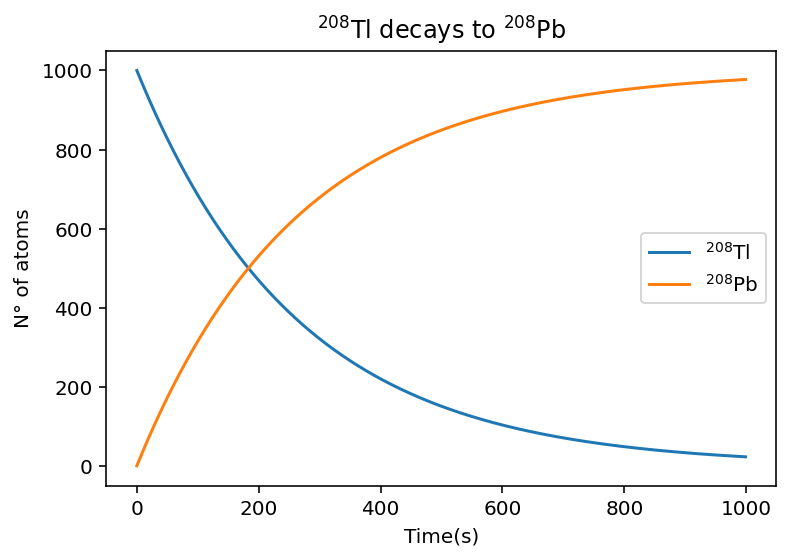

In [92]:
NTl = 1000
tau = 3.052*60
step = [i for i in range(1000)]#1000 secondi

def prob(t):
    p = 1 - 2 **(-t/tau)
    return p

nTl = [NTl*(1-prob(i)) for i in step]
nPb = [1000-i for i in nTl]
plt.plot(step,nTl, label='$^{208}$Tl')
plt.plot(step,nPb, label='$^{208}$Pb')
plt.title('$^{208}$Tl decays to $^{208}$Pb')
plt.xlabel("Time(s)")
plt.ylabel("N° of atoms")
plt.legend(loc='best')
plt.show()

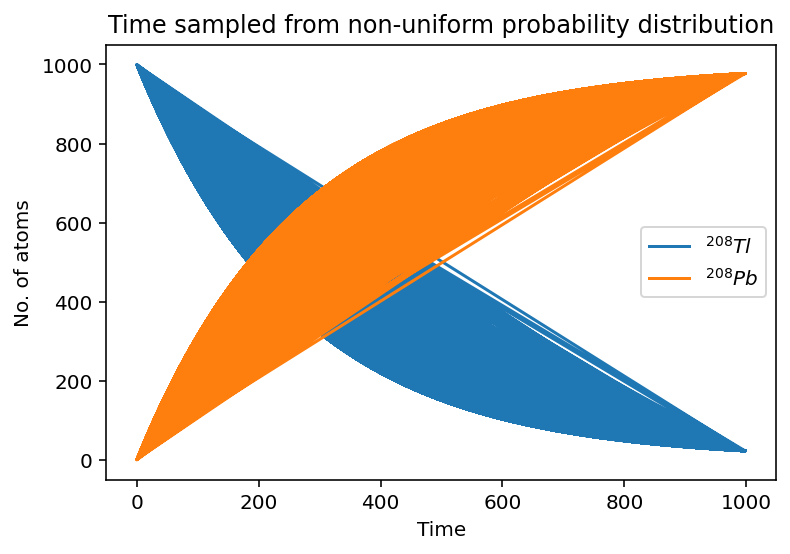

In [126]:
def nu_pdf(t):
    return 2**(-t/tau)*np.log(2)/tau

t = np.linspace(0,step[-1],10000)#time samples
nu_prob = nu_pdf(t)#time prob

t_nu_pdf = np.random.choice(t, size=10000, replace=False, p=(nu_prob)/sum(nu_prob))#samples from nu pdf
t_nu_pdf.sort

plt.plot(t_nu_pdf,1000-prob(t_nu_pdf)*1000,label='$^{208}Tl$')
plt.plot(t_nu_pdf,prob(t_nu_pdf)*1000,label='$^{208}Pb$')
plt.legend()
plt.title("Time sampled from non-uniform probability distribution")
plt.xlabel("Time")
plt.ylabel('No. of atoms')
plt.show()

## 2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [90]:
#constants definition
from scipy import constants as const
%precision 15
a0 = const.physical_constants['Bohr radius']
a0 = a0[0]
Z, pi, e0, e, E, N = 79, const.pi, const.epsilon_0, const.e, (7.7*10**6)*e, 1000000

#beam generation
mean = 0
cov = a0/100
beam = np.random.normal(mean,cov, size=N)

#theta
def theta(b):
    theta = 2*np.arctan((Z*e**2)/(2*pi*e0*E*b))
    return theta

#scattering
bounce = beam[theta(beam) > pi/2].size
print('The % of particles bounced back is:',round(bounce*100/N,1),'%')

The % of particles bounced back is: 2.2 %


## 3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one# 

Integral by Hit or Miss:  0.72511


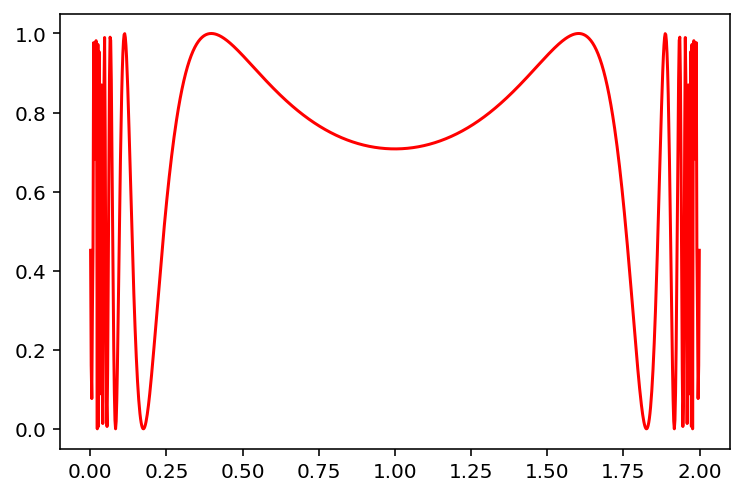

In [47]:
#Hit or Miss
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000) #at x=0 and x=2 very disturbing things happen. There exists singular points.
plt.plot(x,f(x),'r-')

N=100000
count=0
for i in range(N):
    x=np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=count/N
print("Integral by Hit or Miss: ",I)

In [48]:
#Mean Value
I=0
x = np.random.uniform(0,2,size=N)
a = 0
b = 1
I = ((b-a)/N)*np.sum(f(x))
print("Integral by Mean value method:",I)

Integral by Mean value method: 0.7253294666138461


## 4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere


In [3]:
#Using the mean value method for only a quarter of the circle
def y_func(x):
     return np.sqrt(1 - x**2)
I=0
N=10000
x = np.random.uniform(0,1,size=N)
I = 4*(1/N)*np.sum(y_func(x))
print(I)

3.1407273737688453


In [5]:
#https://stackoverflow.com/questions/51091377/how-to-compute-volume-of-10-dimentional-sphere........
def nSphereVolume(dim, iterations):
    count_in_sphere = 0

    for count_loops in range(iterations):
        point = np.random.uniform(-1.0, 1.0, dim)
        distance = np.linalg.norm(point)
        if distance < 1.0:
            count_in_sphere += 1

    return np.power(2.0, dim) * (count_in_sphere / iterations)

print('The Hyper-volume of a 10 dimensional sphere is:',nSphereVolume(10, 100000))
print('The area of a 2 dim circle is:',nSphereVolume(2,100000))

The Hyper-volume of a 10 dimensional sphere is: 2.68288
The area of a 2 dim circle is: 3.13992


## 5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [157]:
N = 1000000
def w(z):
    return 1/np.sqrt(z)

def f(z):
    return z**-0.5/(np.exp(z)+1)

def analytic_integral():
    I, err = quad(w,0,1)
    return I

def inv_transform(x): #inverse transform method for sampling
    return np.square(x)/4

x = np.random.uniform(0,2,size=N)
xs = inv_transform(x)
I = (1/N)*np.sum(f(xs)/w(xs))*2
round(I,2)

0.84